In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
import optuna
import catboost as cb

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv')

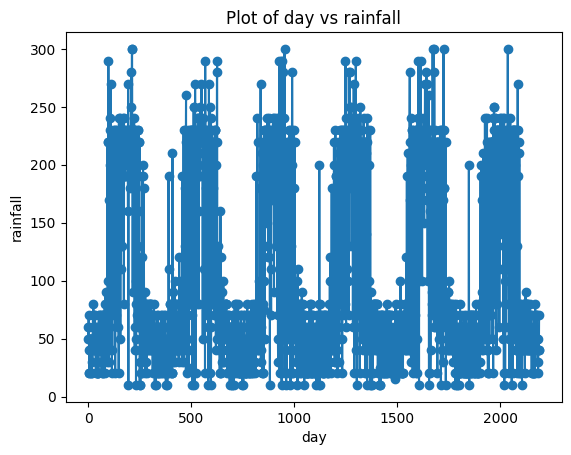

In [6]:
plt.plot(train['id'], train['winddirection'], marker='o', linestyle='-')

# Adding labels and title
plt.xlabel('day')
plt.ylabel('rainfall')
plt.title('Plot of day vs rainfall')

# Showing the plot
plt.show()

No Nan values in train
One NaN in test, which we replace with 0.

In [19]:
test['winddirection'] = test['winddirection'].fillna(0)
test['rainfall'] = 0

In [27]:
dataframes = [train, test]
total_data = pd.concat(dataframes)

In [29]:
total_data.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [31]:
#window_size = 3
# Calculate the moving average, requiring at least one prior value
def moving_average_function (window_size : int, dataframe: str, column_name: str):
    dataframe['ma'] = dataframe[column_name].rolling(window=window_size, min_periods=1).mean()
    return dataframe

In [33]:
moving_average_function(3, total_data, pressure)

NameError: name 'pressure' is not defined

In [9]:
X = train.drop(columns=['rainfall','day'])  
y = train['rainfall']

In [10]:

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=101, max_depth=3, random_state=42)
clf.fit(X_train, y_train)
#y_pred = clf.pred(X_test)
print ('roc auc score', roc_auc_score(y_val, clf.predict_proba(X_val)[:, 1]))

roc auc score 0.8615157661810806


In [12]:
from sklearn.ensemble import AdaBoostClassifier
best_params = {'n_estimators': 43, 'learning_rate': 0.5260253059289932}
clfAda = AdaBoostClassifier(**best_params, random_state=42)
clfAda.fit(X_train, y_train)
print ('roc auc score', roc_auc_score(y_val, clfAda.predict_proba(X_val)[:, 1]))

roc auc score 0.8750954927425516


In [13]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 10.0),
        'random_state': 42
    }

    model = AdaBoostClassifier(**params)
    
    model.fit(
        X_train, y_train,
    )
    
    y_pred = model.predict_proba(X_val)[:, 1]
    
    roc_auc = roc_auc_score(y_val, y_pred)
    
    return roc_auc

In [14]:
#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=150)

#best_params = study.best_params
#best_score = study.best_value

#print("Best Hyperparameters:", best_params)
#print("Best ROC AUC Score:", best_score)

In [15]:
params = {
    'iterations': 1000,
    'learning_rate': 0.2,
    'depth': 10,
    'l2_leaf_reg': 3.0,
    'border_count': 100,
    'bagging_temperature': 0.11750587821495484,
    'random_strength': 1.473221029501774,
    'verbose': 0,
    'random_state': 42
}
model = CatBoostClassifier(**params)
    
model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    early_stopping_rounds=30,
    verbose=0
)
    
y_pred = model.predict_proba(X_val)[:, 1]
    
print ('roc auc score',roc_auc_score(y_val, y_pred))

roc auc score 0.8642027343852902


In [16]:
test_X = test.drop(columns=['day'])
submission = pd.DataFrame({'id': test.id, 'rainfall':clfAda.predict_proba(test_X)[:, 1] })
print(submission.head())

     id  rainfall
0  2190  0.738037
1  2191  0.738037
2  2192  0.544914
3  2193  0.479887
4  2194  0.475367


In [17]:
submission.to_csv('submission.csv', index=False)